Code modified from models/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb of github.com/tensorflow/

## Imports

In [1]:
import os
import pathlib

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import utils 

%matplotlib inline

# Pretrained model

In [3]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '../models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Cat dog dataset

In [4]:
import glob

In [5]:
dog_class_id = 1
num_classes = 1
label_id_offset = 1
category_index = {dog_class_id: {'id': dog_class_id, 'name': 'rubber_ducky'}}

tf.Tensor([[0.03351955 0.248      0.5251397  0.522     ]], shape=(1, 4), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


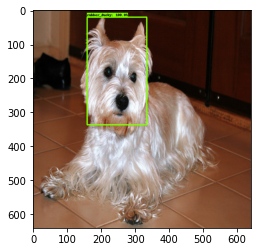

In [6]:
import xml.etree.ElementTree as ET

dataset_path = "data/oxford-pet"
def read_annotation(im_name):
    annotation_path = os.path.join(dataset_path, "annotations", "xmls", f"{im_name}.xml")
    tree = ET.parse(annotation_path)
    bndbox = tree.getroot().find("object").find("bndbox")
    height = float(tree.getroot().find("size").find("height").text)
    width = float(tree.getroot().find("size").find("width").text)
    bdbox_coord = ["ymin", "xmin","ymax","xmax"]
    dims = [height, width, height, width]
    box = [float(bndbox.find(coord).text) / dim for coord,dim in zip(bdbox_coord,dims)]
    return np.array([box])

def get_im_path(im_name):
    return os.path.join(dataset_path, "images", f"{im_name}.jpg")

def get_dog_dataset(batch_size=2, im_size=()):
    paths = glob.glob(get_im_path("[a-z]*"))
    names = [os.path.basename(p)[:-4] for p in paths]
    names = [n for  n in names if os.path.isfile(os.path.join(dataset_path, "annotations", "xmls", f"{n}.xml"))]
    bounding_boxes = [read_annotation(name) for name in names]
    name_label_list = list(zip(names,bounding_boxes))
    
    def _generator():
        np.random.shuffle(name_label_list)
        for name,y in name_label_list:
            np_image = utils.load_image_into_numpy_array(get_im_path(name))
            tf_image = tf.expand_dims(tf.convert_to_tensor(np_image, dtype=tf.float32), axis=0)
            preprocessed_image = detection_model.preprocess(tf_image)[0][0]
            
            
            gt_box_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
            
            zero_indexed_groundtruth_classes = tf.convert_to_tensor(
                    np.ones(shape=[gt_box_tensor.shape[0]], dtype=np.int32) - label_id_offset)
            
            gt_classes_one_hot_tensor = tf.one_hot(
                  zero_indexed_groundtruth_classes, num_classes)
            
            yield preprocessed_image, gt_box_tensor, gt_classes_one_hot_tensor

    dataset = tf.data.Dataset.from_generator(_generator, (tf.float32, tf.float32, tf.float32))
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

def test_dataset():
    for x,y,z in get_dog_dataset(batch_size=4).take(1):
        pass
    box = y[0].numpy()
    dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
    np_image = x[0].numpy()
    np_image = (np_image - np.min(np_image, axis=(0,1), keepdims=True)) / (np.max(np_image, axis=(0,1), keepdims=True)-np.min(np_image, axis=(0,1), keepdims=True)) 
    utils.plot_detections(
          np.array(np_image*255, dtype=np.int),
          box,
          np.ones(shape=[box.shape[0]], dtype=np.int32),
          dummy_scores, category_index)
    print(y[0])
    print(z[0])
    
test_dataset()

# Eager mode custom training loop



In [7]:
import tqdm.notebook as tqdm

In [8]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  #@tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      prediction_dict = model.predict(image_tensors, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)
checkpoint = tf.train.Checkpoint(model=detection_model)
'''
print('Start fine-tuning!', flush=True)
count = 0
for i in range(3):
    for im, box, label in tqdm.tqdm(get_dog_dataset()):
        # Training step (forward pass + backwards pass)
        total_loss = train_step_fn(im, box, label)

        count += 1
        if count % 50 == 0:
            print('batch ' + str(count) 
            + ', loss=' +  str(total_loss.numpy()), flush=True)
    print(checkpoint.save('models/detection/checkpoints/dog-finetuned-checkpoint'))

print('Done fine-tuning!')
'''

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Start fine-tuning!


batch 50, loss=2.5282872
batch 100, loss=1.2610176
batch 150, loss=1.6165917
batch 200, loss=1.2484292
batch 250, loss=1.3482909
batch 300, loss=2.42924
batch 350, loss=2.4593933
batch 400, loss=2.252844
batch 450, loss=1.9216799
batch 500, loss=1.957891
batch 550, loss=1.116064
batch 600, loss=2.1767657
batch 650, loss=1.3681006
batch 700, loss=1.0195525
batch 750, loss=1.7347033
batch 800, loss=1.8592997
batch 850, loss=1.513486
batch 900, loss=4.1073956
batch 950, loss=2.1754284
batch 1000, loss=0.8882073
batch 1050, loss=0.847698
batch 1100, loss=1.365836
batch 1150, loss=1.195355
batch 1200, loss=1.8961143

models/detection/checkpoints/dog-finetuned-checkpoint-1


batch 1250, loss=2.0712595
batch 1300, loss=1.4428725
batch 1350, loss=1.9854659
batch 1400, loss=1.4004364
batch 1450, loss=1.7967618
batch 1500, loss=0.8050444
batch 1550, loss=0.8729954
batch 1600, loss=1.5446812
batch 1650, loss=1.2868292
batch 1700, loss=1.4271264
batch 1750, loss=1.9275897
batch 1800, loss=2.0042906
batch 1850, loss=4.278627
batch 1900, loss=1.0572522
batch 1950, loss=1.1611239
batch 2000, loss=2.4989142
batch 2050, loss=0.8457998
batch 2100, loss=2.0607207
batch 2150, loss=1.2480224
batch 2200, loss=1.5100949
batch 2250, loss=0.72968876
batch 2300, loss=1.1343632
batch 2350, loss=1.8256313
batch 2400, loss=2.7908382
batch 2450, loss=1.8354926

models/detection/checkpoints/dog-finetuned-checkpoint-2


batch 2500, loss=0.9719413
batch 2550, loss=1.3938496
batch 2600, loss=1.7304835
batch 2650, loss=1.1609985
batch 2700, loss=1.1086426
batch 2750, loss=1.038147
batch 2800, loss=1.2478775
batch 2850, loss=2.2702758
batch 2900, loss=1.3146511
batch 2950, loss=2.1865091
batch 3000, loss=2.0724497
batch 3050, loss=0.9274724
batch 3100, loss=1.484882
batch 3150, loss=2.7882667
batch 3200, loss=1.5170871
batch 3250, loss=0.6415798
batch 3300, loss=1.0617236
batch 3350, loss=0.96909696
batch 3400, loss=0.8619134
batch 3450, loss=1.3505344
batch 3500, loss=1.2732233
batch 3550, loss=2.2380714
batch 3600, loss=1.4910716
batch 3650, loss=1.7120639
batch 3700, loss=2.2532449

models/detection/checkpoints/dog-finetuned-checkpoint-3
Done fine-tuning!


# Test on new image

In [15]:
checkpoint.restore('models/detection/checkpoints/dog-finetuned-checkpoint-2')

In [ ]:
def file_generator():

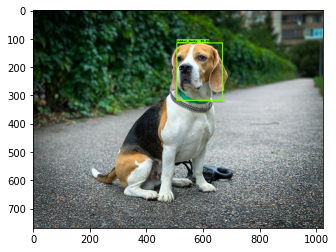

In [26]:
test_image_path = "data/dogs-1024/50562567067.jpg"
test_image_np = np.expand_dims(utils.load_image_into_numpy_array(test_image_path), axis=0)

@tf.function
def detect(input_tensor):
      """Run detection on an input image.

      Args:
        input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
          Note that height and width can be anything since the image will be
          immediately resized according to the needs of the model within this
          function.

      Returns:
        A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
          and `detection_scores`).
      """
      preprocessed_image, shapes = detection_model.preprocess(input_tensor)
      prediction_dict = detection_model.predict(preprocessed_image, shapes)
      return detection_model.postprocess(prediction_dict, shapes)

input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32) 
detections = detect(input_tensor)

utils.plot_detections(
    test_image_np[0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index, figsize=(15, 20))